## Road signs classifier

**Artur Skowroński 411423**\
**Szymon Socha 411462**

The aim of our project, is to create the most optimal model possible that can recognise individual road signs.
To do this, we used the publicly available dataset [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) containing more than 50,000 images of 43 traffic signs.
In order to test which of the algorithms for the image classification problem works best, we decided to use the following algorithms:
- RandomForest
- LightGBM (we are aware that we discussed another boosting model in class - XGBoost, however this one is definitely faster)
- Convolutional Neural Networks

Due to the fact that the dataset we have chosen is quite large and, in addition, we will be using neural networks, we have decided that we will use the resources of Google Drive, to which we can directly download images from Kaggle, and Google Colab, which will help us with faster calculations, without burdening the local machine.

With this in mind, we also include [instruction](https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07) on how to directly link a Google Drive account to a Kaggle account for our work.


### 1. Import libraries

In [1]:
# Data analysis
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Image preprocessing/data preparation
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Modelling

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

from keras.preprocessing.image import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Validation metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Model savings
import joblib
import pickle
from keras.models import load_model

from matplotlib import style
style.use('fivethirtyeight')
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/road-signs-NN")

Below, we inserted the code which helped us upload the data directly from Kaggle into Google Drive.

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/road-signs-NN"

# %cd /content/drive/MyDrive/road-signs-NN

# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --unzip

**Setting parameters**

In [4]:
# Paths
train_path = '/content/drive/MyDrive/road-signs-NN/Train'
test_path = '/content/drive/MyDrive/road-signs-NN/Test'

# Resizing the images to 32x32x1
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Total number of categories
NUM_CATEGORIES = len(os.listdir(train_path))
print(f'Dataset containts {NUM_CATEGORIES} different road signs.')

Dataset containts 43 different road signs.


Below, we will name our each road sign.

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

### 2. Exploratory Data Analysis

In order to understand the distribution of the data, we have two helpful datasets in csv files.
Let's see how many pictures do we have in our datasets.

In [6]:
train_tabular = pd.read_csv('Train.csv')
test_tabular = pd.read_csv('Test.csv')

In [7]:
train_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
test_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [9]:
train_df_desc = train_tabular.Path.apply(lambda x: x.split("/")[1])\
                             .value_counts()\
                             .to_frame()\
                             .reset_index()\
                             .rename({"index": "Index", "Path": "Cnt"}, axis=1)

train_df_desc["Class"] = pd.Series(classes)
train_df_desc["Index"].astype("int32")
train_df_desc.head()

,Index,Cnt,Class
0,2,2250,Speed limit (20km/h)
1,1,2220,Speed limit (30km/h)
2,13,2160,Speed limit (50km/h)
3,12,2100,Speed limit (60km/h)
4,38,2070,Speed limit (70km/h)


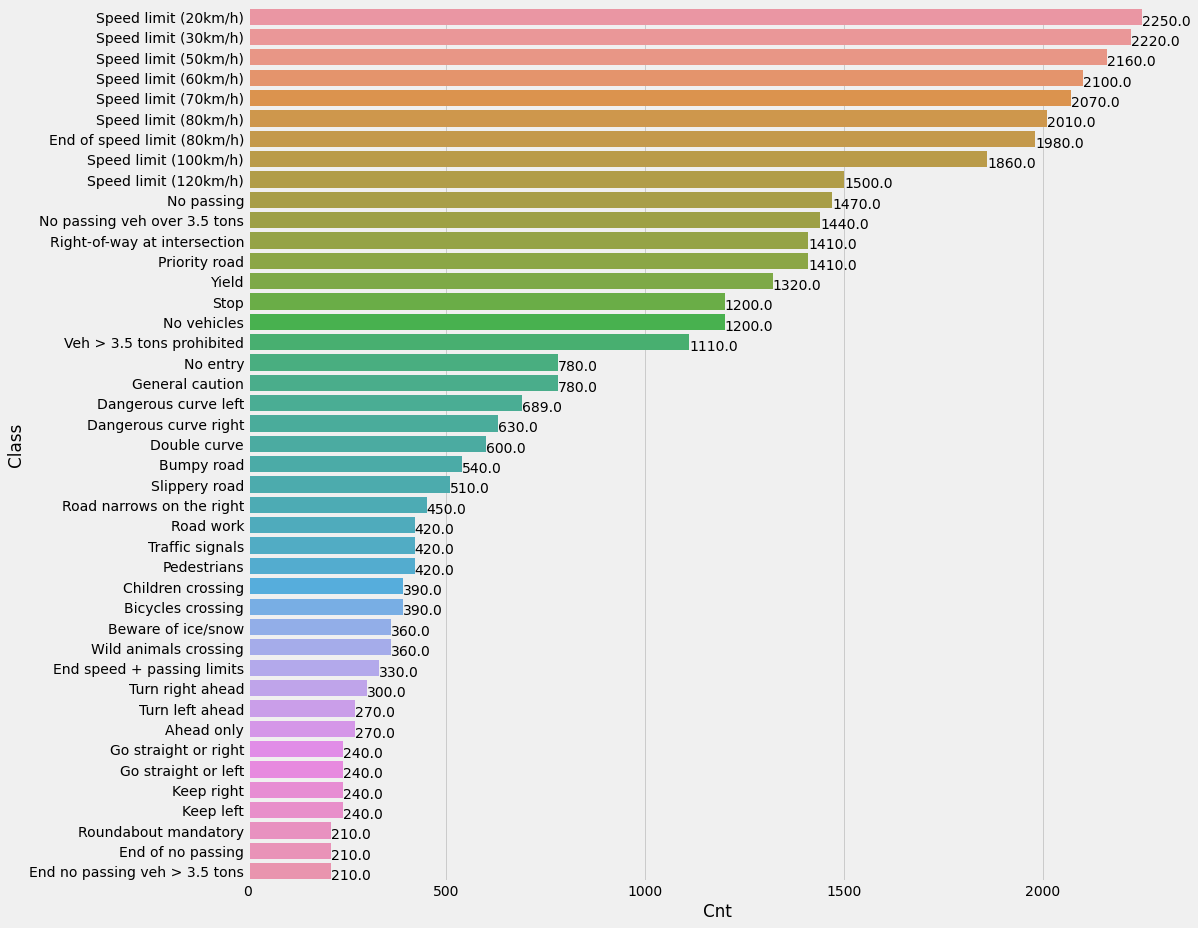

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.barplot(x='Cnt', y='Class', data=train_df_desc)
for p in ax.patches:
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()
                value = p.get_width()
                ax.text(x, y, value, ha="left")

plt.show()

Ok, so we see that the highest number of signs is connected with speed limit signs. This dataset is definitely unbalanced, so it might be worth to do some kind of data augmentation. Nevertheless, at this step we decided to not doing it, in order to check how our model will behave. \

Below we decided to show, two different signs. In the first case, the sign is quite obvious, so we assume, that our algorithm should not hvae any problem in recognising it. 
However, in the second example, on the first glance, it might be hard to estimate was sign is that.

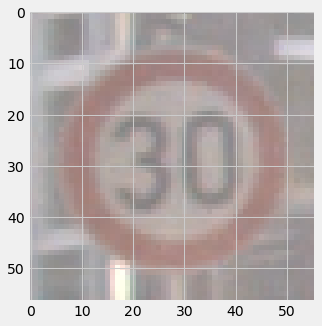

In [ ]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/1/00001_00000_00000.png').convert('RGB')
plt.imshow(pic)

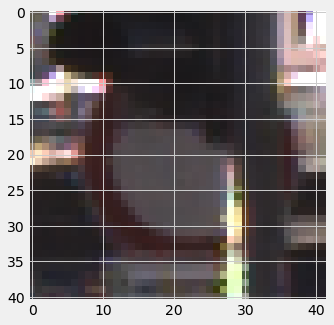

In [ ]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/15/00015_00000_00000.png').convert('RGB')
plt.imshow(pic)

We see, that there are many different signs. Some are quite obvious, but other are even hard for human to recognise.

### 3. Data preparation

Images will be rescaled to 32x32 resolution, all transformed to grayscale (single channel image).

In [11]:
# Retrieving the images and their labels 
from tqdm import tqdm
images_list = []
labels = []

for i in tqdm(range(NUM_CATEGORIES)):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for no_image in images:
        try:
            pic = Image.open(path + '/'+ no_image).convert('L')
            image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            pixels = np.array(image)
            image_ravel = pixels.ravel()
            images_list.append(image_ravel)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

100%|██████████| 43/43 [11:33<00:00, 16.13s/it]


We do the same with our test dataset, but the code will be adjusted, because test data is not segregated in folders.

In [12]:
images_list_test = []
labels_test = []

images = [file for file in os.listdir(test_path) if file.endswith('.png')]

for idx, no_image in tqdm(enumerate(images)):
    try:
        pic = Image.open(test_path + '/' + no_image).convert('L')
        image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        pixels = np.array(image)
        image_ravel = pixels.ravel()
        images_list_test.append(image_ravel)
        tmp = test_tabular[test_tabular.Path.str.slice(start=5, stop=14, step=1) == images[idx]].ClassId.values.tolist()[0]
        labels_test.append(tmp)
    except:
        print("Error loading image")

# Converting lists into numpy arrays
X_test_org = np.array(images_list_test)
y_test_org = np.array(labels_test)

12630it [07:06, 29.60it/s]


In [ ]:
# Check if everything is OK
print(X_test_org.shape, y_test_org.shape)

(12630, 1024) (12630,)


#### Spliting into train/valid

Because of the fact, that we don't have any validation data, we have to split training data intro train and valid data. We did by making a proportion: 0.8 for training and 0.2 for validation.

In [13]:
# Splitting training and testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(images_list, labels, test_size=0.2, random_state=42, shuffle=True)

# Displaying the shape after the split
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(31367, 1024) (7842, 1024) (31367,) (7842,)


#### Preview the images



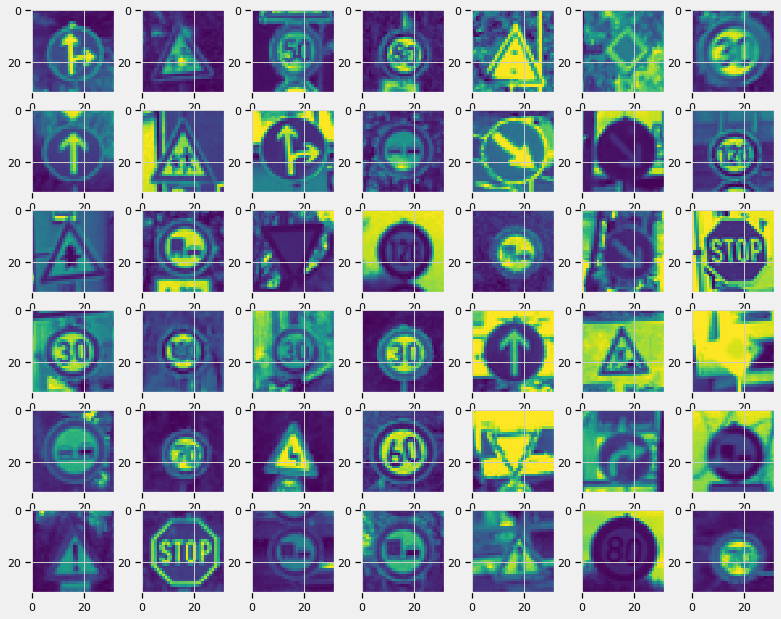

In [ ]:
plt.figure(figsize=(12,10))
x, y = 7, 6
for i in range(42):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((IMG_WIDTH, IMG_HEIGHT)), interpolation='nearest')
plt.show()

Based on above plot, we have successfully managed to convert our images to greyscale.

#### Additional preparations

In [14]:
# Normalization to values between 0 an 1

X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test_org/255.0

In [15]:
# Checking if all dimensions are correct

print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (31367, 1024)
X_valid shape: (7842, 1024)
X_test shape: (12630, 1024)


In [16]:
# Reshaping

dim_to_reshape = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], dim_to_reshape)
X_valid = X_valid.reshape(X_valid.shape[0], dim_to_reshape)
X_test = X_test.reshape(X_test.shape[0], dim_to_reshape)

y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test_org.reshape(-1, 1)

In [17]:
print('x_train shape:', X_train.shape)
print('x_valid shape:', X_valid.shape)
print('x_test shape:', X_test.shape)

x_train shape: (31367, 1024)
x_valid shape: (7842, 1024)
x_test shape: (12630, 1024)


### 4. Modelling

After finding the best optimal hyperparameters for our each model, we will save it in order to not recalculating it, which will be very helpful.
What's more, especially in case of Neural Networks, the fitting time is taking so long, so we recommend to just upload are prepared earlier model.

#### 4.1. Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
{'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)], 
 'max_depth': [int(x) for x in np.linspace(2, 6, num = 4)],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]} 
]

grid_search_forest = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', random_state=42)
grid_search_forest.fit(X_train, y_train.ravel())

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions=[{'max_depth': [2, 3, 4, 6],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [50, 100, 150, 200,
                                                          250, 300]}],
                   random_state=42, scoring='accuracy')

In [ ]:
# Save best estimator from random forest

import joblib
joblib.dump(grid_search_forest.best_estimator_, '/content/drive/MyDrive/road-signs-NN/models/random_forest_best_est.pkl')

['/content/drive/MyDrive/road-signs-NN/models/random_forest_best_est.pkl']

Score function as default has implemented accuracy_score.

In [18]:
loaded_rf_model = joblib.load('/content/drive/MyDrive/road-signs-NN/models/random_forest_best_est.pkl')
rf_result_valid = loaded_rf_model.score(X_valid, y_valid)
rf_result_test = loaded_rf_model.score(X_test, y_test)

print(f'Random Forest validation accuracy: {100*np.round(rf_result_valid, 2)}%')
print(f'Random Forest test accuracy: {100*np.round(rf_result_test, 2)}%')

Random Forest validation accuracy: 61.0%
Random Forest test accuracy: 51.0%


The results obtained from Random Forest are certainly not satisfactory, especially as we score a significant drop in accuracy between the validation and test set.

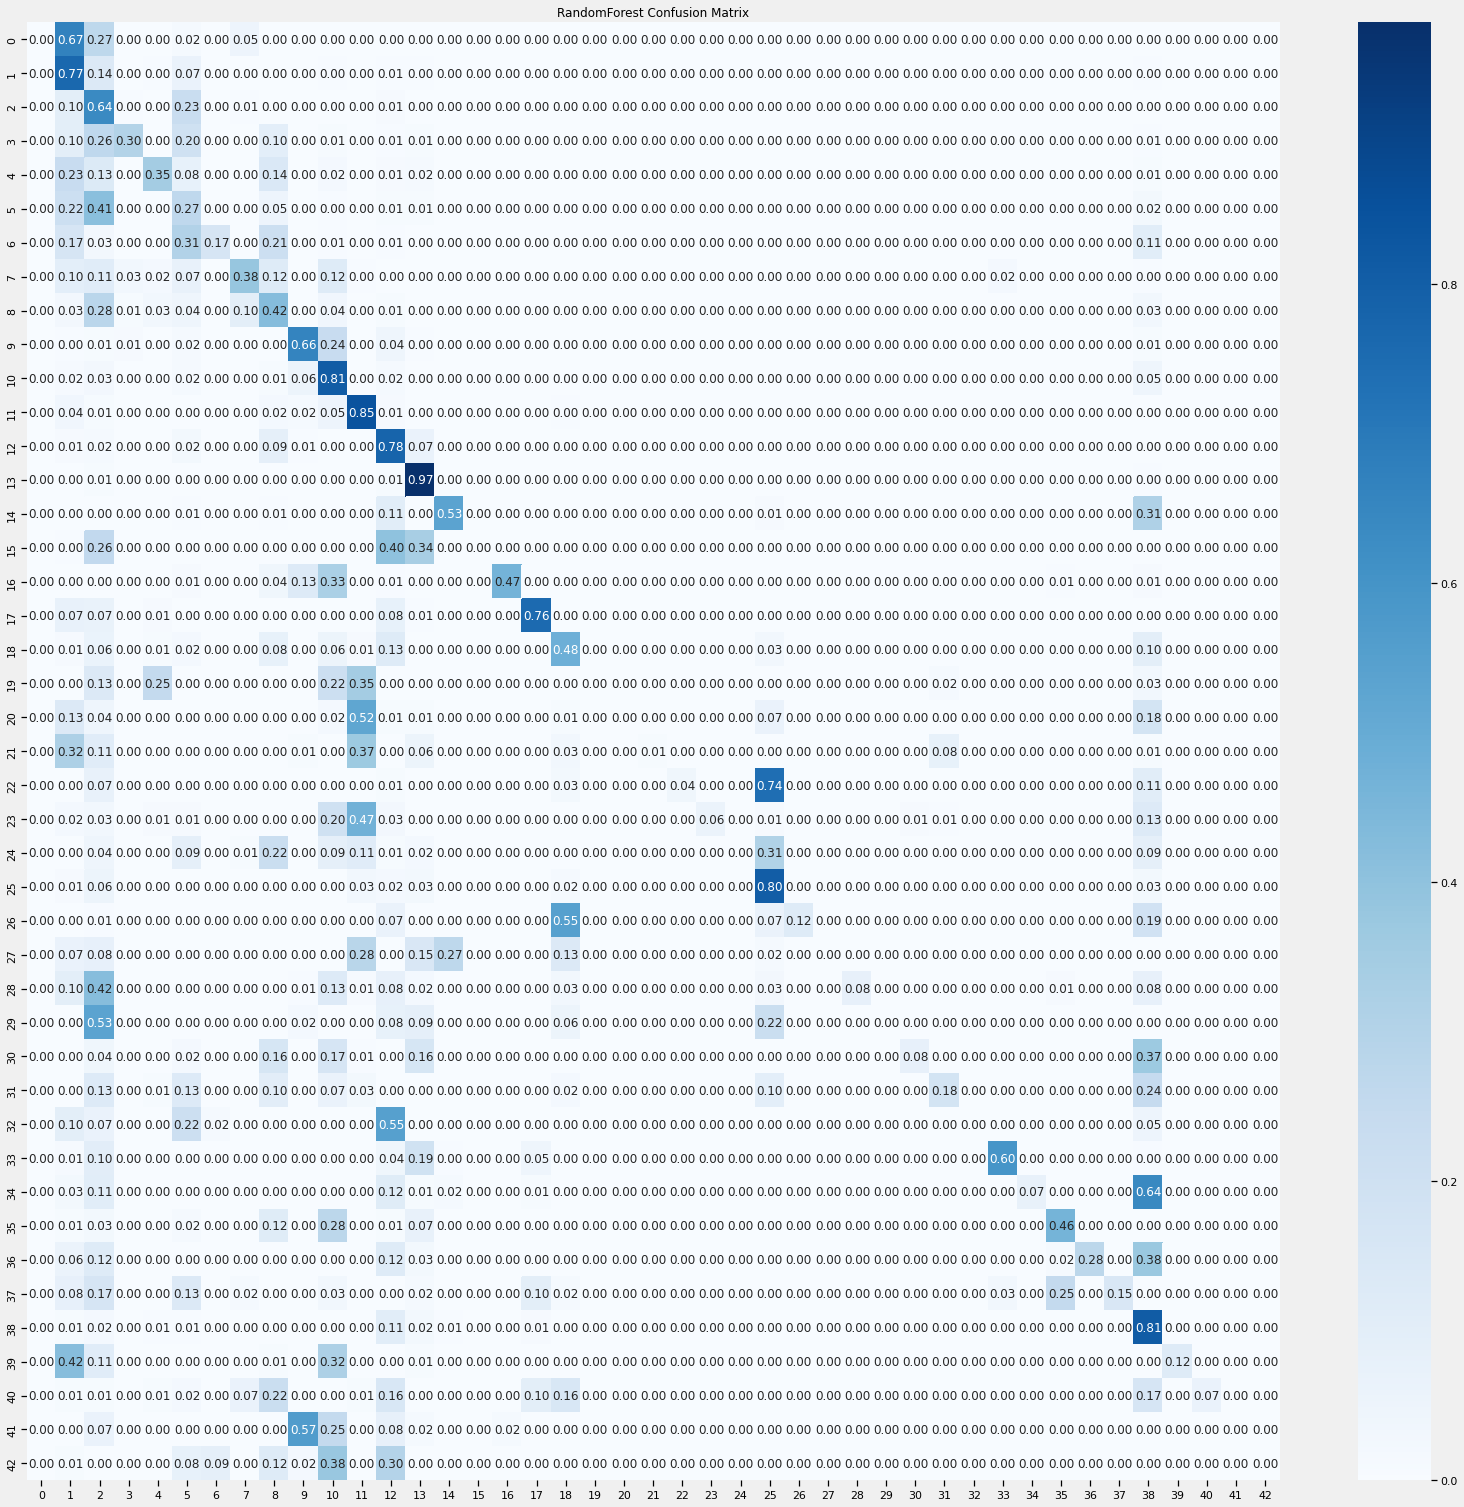

In [19]:
# Calculate predictions
rf_predictions = loaded_rf_model.predict(X_test)
  
# creating a confusion matrix 
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_rf, annot = True, fmt='.2f', cmap="Blues").set_title("RandomForest Confusion Matrix")
plt.show()

In the graph above, we can see that there are road signs that have not been correctly classified even once.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


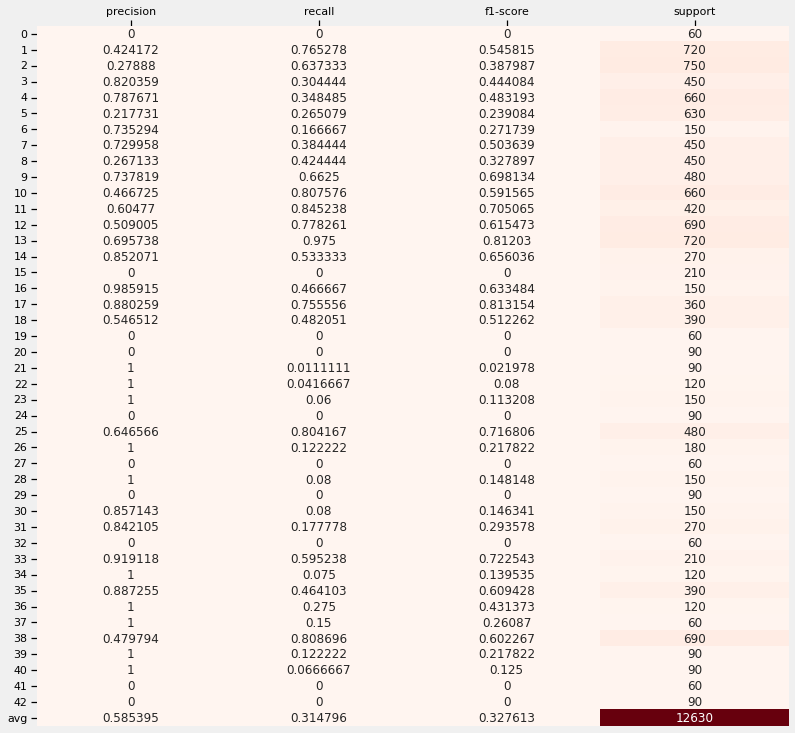

In [20]:
# Classification report
# resource: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report (adjusted to our needs)

def plot_classification_report(y_true, y_pred):

    plt.figure(figsize=(12, 12))

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_true))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_true, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    ax = sns.heatmap(rep,
                    annot=True, 
                    cbar=False, 
                    xticklabels=xticks, 
                    yticklabels=yticks,
                    cmap="Reds",
                    fmt='g')
    ax.xaxis.set_ticks_position('top')

plot_classification_report(y_test, rf_predictions)

##### 4.2. LightGBM

Admittedly, we discussed boosting based on XGBoost in class, but we decided to choose the LightGBM model because of its better conversion speed compared to XGBoost and its growing popularity.

Unfortunately, in this case it takes much longer (around 6 hours) to optimise the parameters in comparison to the RandomForest model, so we suggest using an already loaded model, available in the models folder.

In [21]:
y_train_lgb = y_train.flatten()
y_valid_lgb = y_valid.flatten()
y_test_lgb = y_test.flatten()

In [ ]:
import lightgbm as lgb

param_grid = [
{'n_estimators': [10, 50, 100, 300, 500], 
 'learning_rate': [0.0001, 0.001, 0.01],
 'subsample': [0.5, 0.7, 1.0],
 'max_depth': [3, 5, 7, 10],
 'multiclass': ['softmax'],
 'num_class': [43]
}]

grid_search_lgb = RandomizedSearchCV(lgb.LGBMClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_lgb.fit(X_train, y_train_lgb)

joblib.dump(grid_search_forest.best_estimator_, '/content/drive/MyDrive/road-signs-NN/models/lightgbm_best_est.pkl')

In [22]:
loaded_lgb_model = joblib.load('lightgbm_best_est.pkl')

valid_result_lgb = loaded_lgb_model.score(X_valid, y_valid_lgb)
test_result_lgb = loaded_lgb_model.score(X_test, y_test_lgb)

print(f'Light GBM validation accuracy: {100*np.round(valid_result_lgb, 2)}%')
print(f'Light GBM test accuracy: {100*np.round(test_result_lgb, 2)}%')

Light GBM validation accuracy: 86.0%
Light GBM test accuracy: 68.0%


While we were able to obtain better results compared to RandomForest, we are still not satisfied with the fact that there is so much difference between the validation set and the test set.

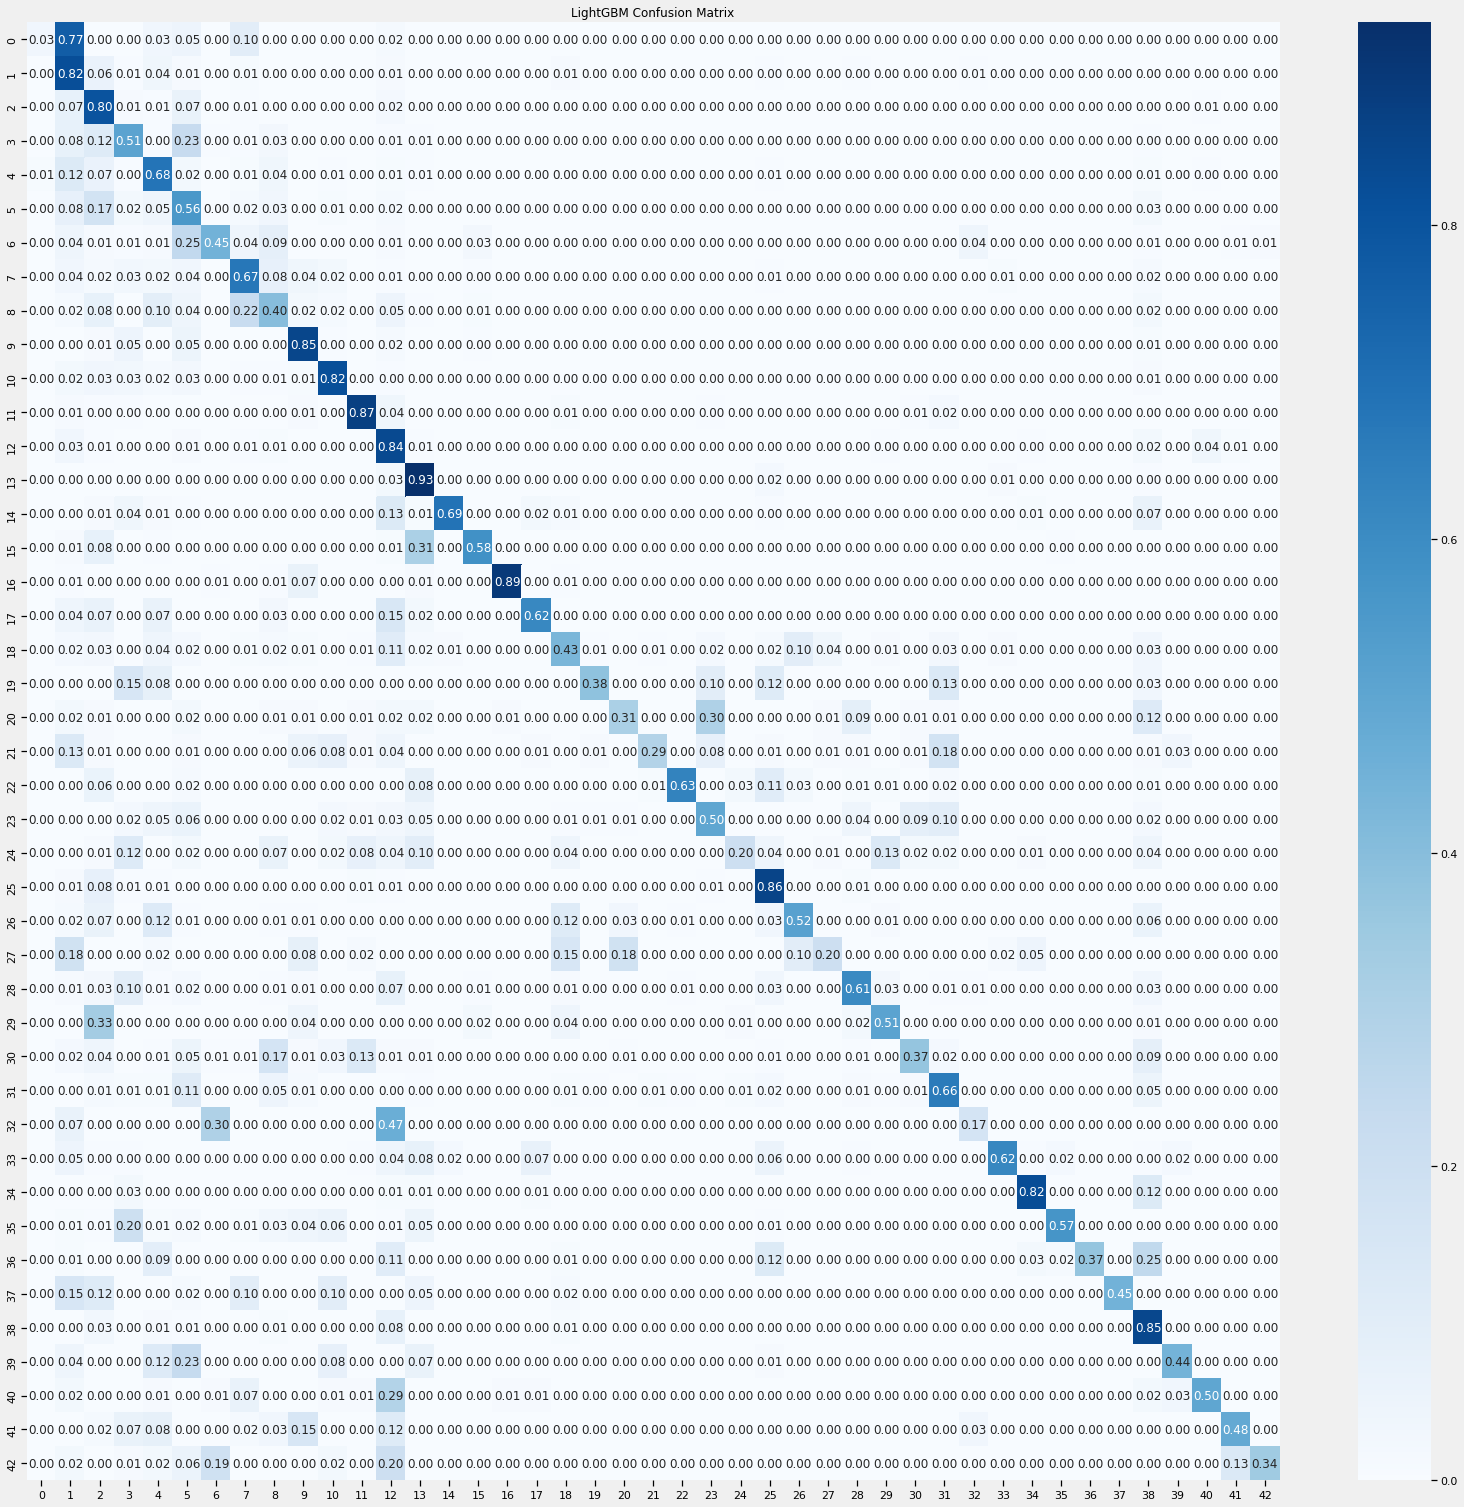

In [23]:
# Calculate predictions

lgb_predictions = loaded_lgb_model.predict(X_test)
cm_lgb = confusion_matrix(y_test, lgb_predictions)
cm_lgb = cm_lgb.astype('float') / cm_lgb.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_lgb, annot = True, fmt='.2f', cmap="Blues").set_title("LightGBM Confusion Matrix")
plt.show()

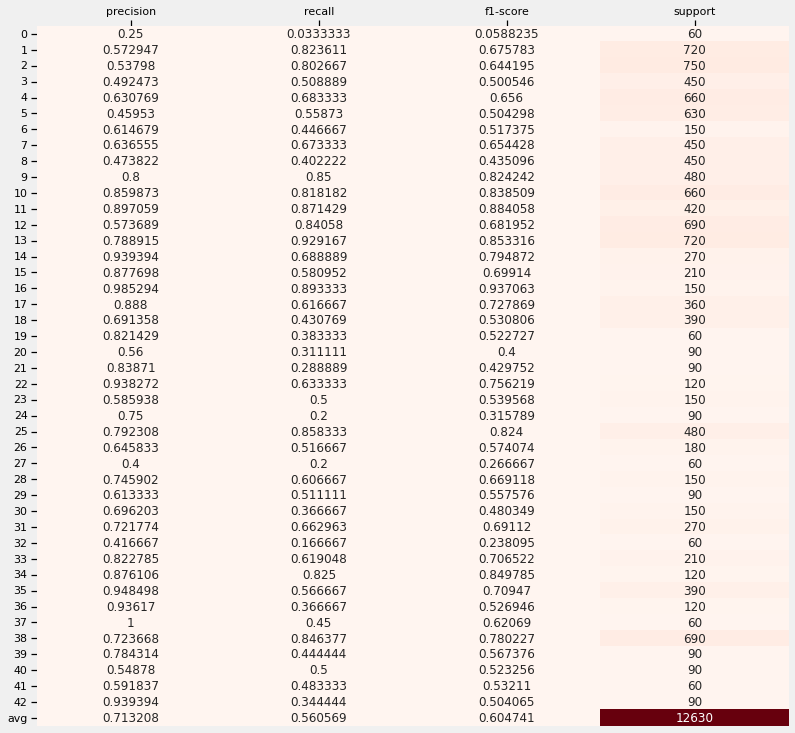

In [24]:
plot_classification_report(y_test, lgb_predictions)

What is pleasing, however, is that our model, despite being wrong, is able to identify correctly at least once, every road sign.

##### 4.3. Neural Networks - CNN

In case of Neural Networks, the data should be transformed a little bit:
- X labels should be in this shape: (records, image_width, image_height, channels)
- we have multiclassification problem, so model compile process should consists of loss = 'categorical_crossentropy', that's why our y variables, should be changed into one hot encoding

In [25]:
# reshaping for cnn (keras requires input to be three-dimensional - in case of images with colours)

X_train = X_train.reshape(X_train.shape[0], 32, 32,1)
X_valid = X_valid.reshape(X_valid.shape[0], 32, 32,1)
X_test = X_test_org.reshape(X_test.shape[0], 32, 32,1)

y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In order to test the various possibilities for CNN, with the aim of achieving the best possible model, we decided to build up several networks based on LeNet-5 architecture, which is the one of the first architectures build in 1998 by Yann LeCun et al.

For our needs, we dropped two convolutional layers and one pooling layer. 
What's more we decided to build our model based on different number of filters.
This trick enabled us to get 5 different models.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

filters = [3, 5, 9, 13, 15]
models = {}

for key, value in enumerate(filters):

    try:
        print(f'Calculation of the model {key} with {value} filters has just started!')

        tmp_model = Sequential()
        tmp_model.add(Rescaling(1, input_shape=(32, 32, 1)))
        tmp_model.add(Conv2D(6, kernel_size=value, padding='same', activation='relu'))
        tmp_model.add(AveragePooling2D(pool_size=2))
        tmp_model.add(Dropout(0.2))
        tmp_model.add(Flatten())
        tmp_model.add(Dense(130, activation='relu'))
        tmp_model.add(Dense(43, activation='softmax'))
        tmp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        print(f'Calculation of the model {key} with {value} filters has successfully finished!')
        print('-'*30)
    except:
        print('Something went wrong !')

    models[f'model_{key}'] = tmp_model

Calculation of the model 0 with 3 filters has just started!
Calculation of the model 0 with 3 filters has successfully finished!
------------------------------
Calculation of the model 1 with 5 filters has just started!
Calculation of the model 1 with 5 filters has successfully finished!
------------------------------
Calculation of the model 2 with 9 filters has just started!
Calculation of the model 2 with 9 filters has successfully finished!
------------------------------
Calculation of the model 3 with 13 filters has just started!
Calculation of the model 3 with 13 filters has successfully finished!
------------------------------
Calculation of the model 4 with 15 filters has just started!
Calculation of the model 4 with 15 filters has successfully finished!
------------------------------


Since, with previous models, the results on our validation set and test set differed strongly from each other, we speculate that our models may have adapted too much to the training data and therefore our model overtrained.

In order to improve the results, we decided to observe the loss for the validation set when training the network, so as to avoid overtraining. When, our algorithm sees that for the next 3 epochs the loss does not change, we instruct it to stop training and save the model.

**NOTE**, it took around 1,5 hours on google colab (runtime: TPU) to fit the models. Nonetheless, we have already included the recalculated best model below (in models folders as well as history of the model in history folder), which we will rely on in the further stages of model verification.

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

epochs = 50
history = {}

for i in range(len(models)):
    try:
        print(f'Model {i} is started being fitted!')
        print('')

        history[f'model_{i}_history'] = models[f'model_{i}'].fit(X_train, 
                                                                  y_train,
                                                                  epochs = epochs,
                                                                  validation_data=(X_valid, y_valid),
                                                                  callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                                                                               ModelCheckpoint(f'/content/drive/MyDrive/road-signs-NN/models/CNN_model_{i}.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')],
                                                                  verbose=0)

        with open(f'/content/drive/MyDrive/road-signs-NN/history/CNN_model_history_{i}', 'wb') as file_pi:
            pickle.dump(history[f'model_{i}_history'].history, file_pi)
        
        print(f'''Model {i} has succesfully being fitted!
              Total number of epochs is equal to {len(history[f'model_{i}_history'].history['loss'])}
              The highest training accuracy is equal to {max(history[f'model_{i}_history'].history['accuracy'])}.
              The highest validation accuracy is equal to {max(history[f'model_{i}_history'].history['val_accuracy'])}.
              ''')
        print('-'*40)
    except:
        print('Something went wrong')


Model 0 is started being fitted!

Model 0 has succesfully being fitted!
              Total number of epochs is equal to 25
              The highest training accuracy is equal to 0.9787675142288208.
              The highest validation accuracy is equal to 0.9743688106536865.
              
----------------------------------------
Model 1 is started being fitted!

Model 1 has succesfully being fitted!
              Total number of epochs is equal to 16
              The highest training accuracy is equal to 0.9774284958839417.
              The highest validation accuracy is equal to 0.9753889441490173.
              
----------------------------------------
Model 2 is started being fitted!

Model 2 has succesfully being fitted!
              Total number of epochs is equal to 24
              The highest training accuracy is equal to 0.9860044121742249.
              The highest validation accuracy is equal to 0.9794695377349854.
              
---------------------------------------

Model 2 has the best both training and validation accuracy, that's why it will be taken into account in the next steps.

In [26]:
with open('/content/drive/MyDrive/road-signs-NN/history/CNN_model_history_2', "rb") as file_pi:
    history_final = pickle.load(file_pi)

In [27]:
model_final = load_model('/content/drive/MyDrive/road-signs-NN/models/CNN_model_2.h5')
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         492       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 6)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 130)               199810    
                                                      

The best seems to be model 2, thats why I will save it for later.

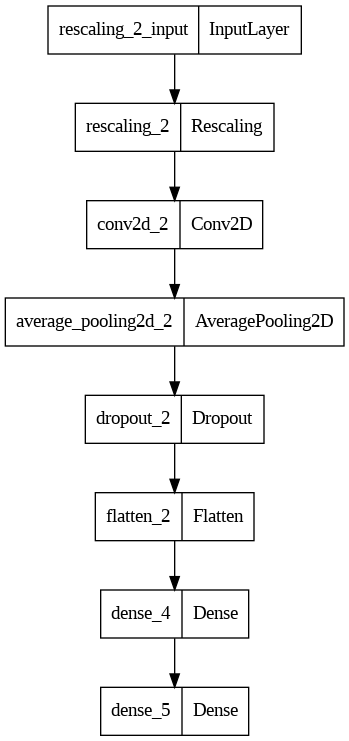

In [28]:
# Final model architecture
from keras.utils import plot_model
plot_model(model_final)

In [29]:
val_loss, val_acc = model_final.evaluate(X_valid, y_valid, verbose=2)
print('\nValidation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

test_loss, test_acc = model_final.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

246/246 - 6s - loss: 0.1155 - accuracy: 0.9790 - 6s/epoch - 26ms/step

Validation accuracy: 0.9789594411849976

Validation loss: 0.11548003554344177
395/395 - 9s - loss: 179.1498 - accuracy: 0.8725 - 9s/epoch - 23ms/step

Test accuracy: 0.8725257515907288

Test loss: 179.14976501464844


While it is true that the loss on the validation set was reduced while achieving high accuracy, the same cannot be said for the test set. 
Furthermore, our test set achieved a high loss function value. This indicates that the test set may have had some outliers, which the trained model could not correctly identify and which dramatically increased the loss value. \
However, let's see how the training history went for our network.

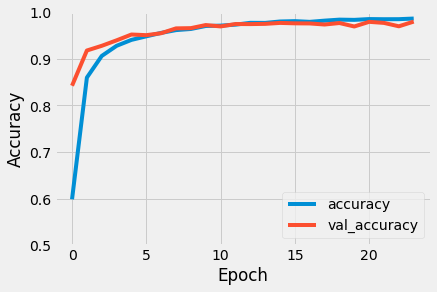

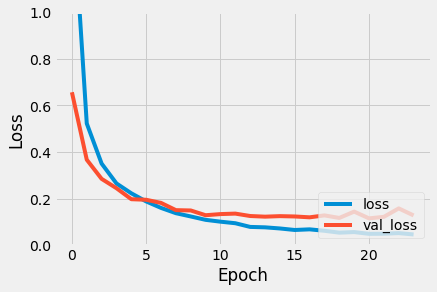

In [ ]:
plt.figure(0)
plt.plot(history_final['accuracy'], label='accuracy')
plt.plot(history_final['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history_final['loss'], label='loss')
plt.plot(history_final['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

From the graph above, that the decision to stop the model when there was no improvement in the loss function on the validation set was justified. We can see that the model was already starting to adapt more and more to the training data from epoch 10 onwards, even though the accuracy was fairly similar.

395/395 [==============================] - 12s 31ms/step


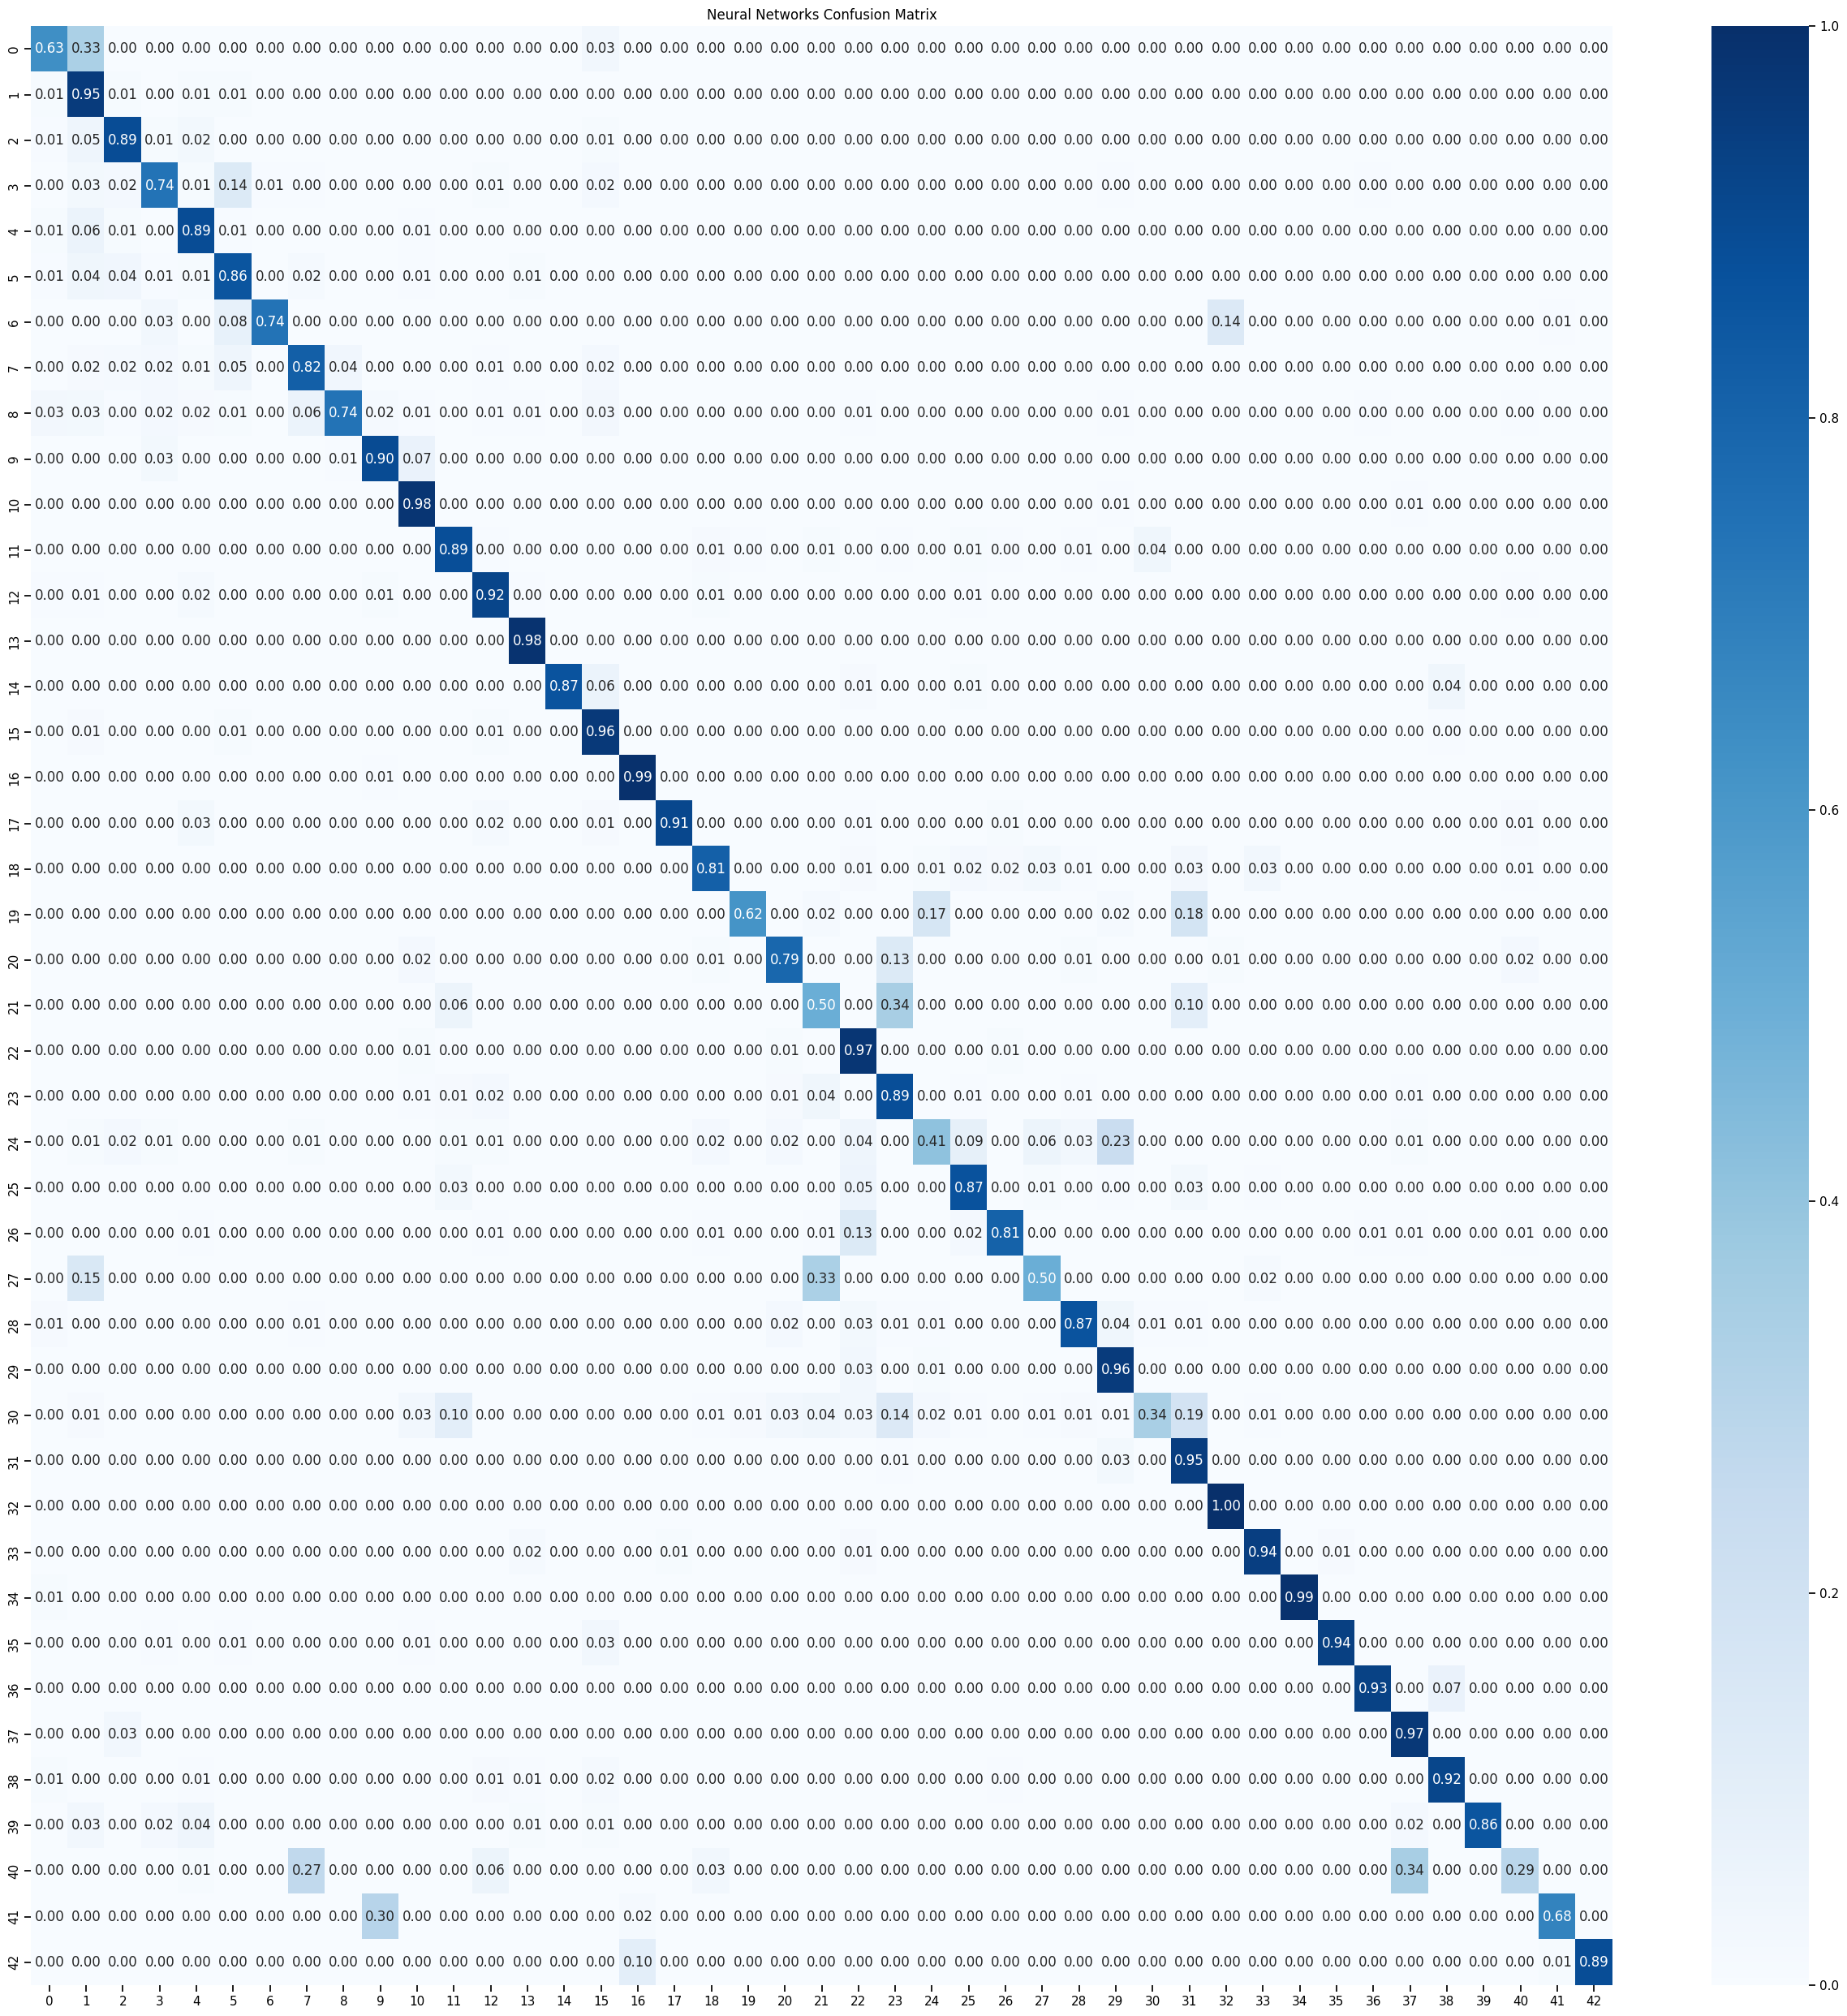

In [37]:
# Calculate predictions
# Predict the values from the test dataset
Y_pred = model_final.predict(X_test)
# Convert one hot encoding to arg max
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert test observations to arg max
Y_true = np.argmax(y_test, axis=1)
  
# creating a confusion matrix 
cm_nn = confusion_matrix(Y_true, Y_pred_classes)
cm_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_nn, annot = True, fmt='.2f', cmap="Blues").set_title("Neural Networks Confusion Matrix")
plt.tight_layout()

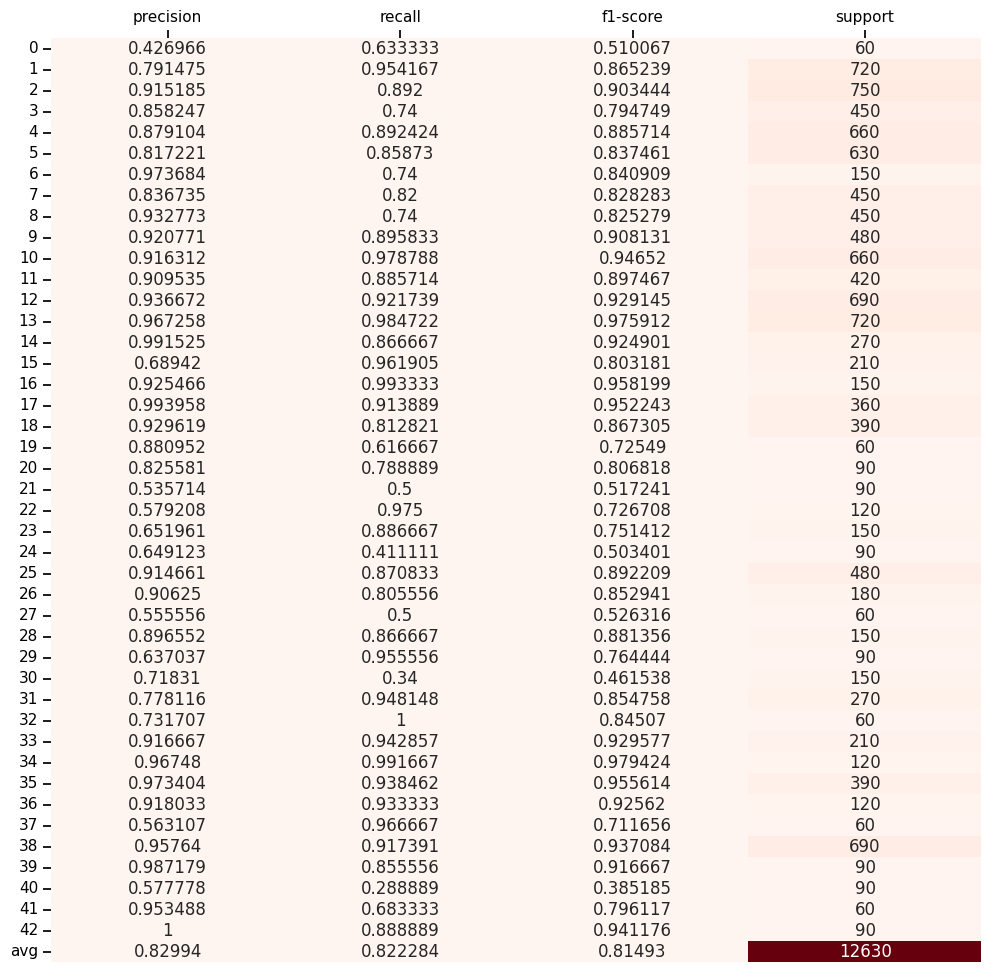

In [38]:
#get the predictions for the test data
plot_classification_report(Y_true, Y_pred_classes)

#### Model with data augmentation

We know from the data analysis that our collection is unbalanced. Therefore, on the architecture of the models on which we obtained the highest accuracy we decided this for data augmentation. \
Below is an example photo of a 'right turn' road sign and its various possible modifications. For the purpose of presentation, the colours of the photos have not been changed.

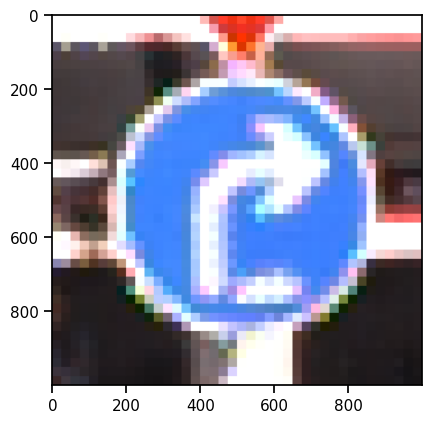

In [41]:
photo_example = keras.preprocessing.image.load_img(f'{train_path}/33/00033_00001_00016.png', target_size= (1000,1000))
img_tensor = keras.preprocessing.image.img_to_array(photo_example)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(photo_example)

Our function will not allow new images to be created by vertical or horizontal modification, as a right-hand sign could become a left-hand sign, which would affect the final result.
Therefore, we have selected only the basic photo modification options such as rotation, shifting, shearing and zooming. What's more, we decided to augment the images on the fly.

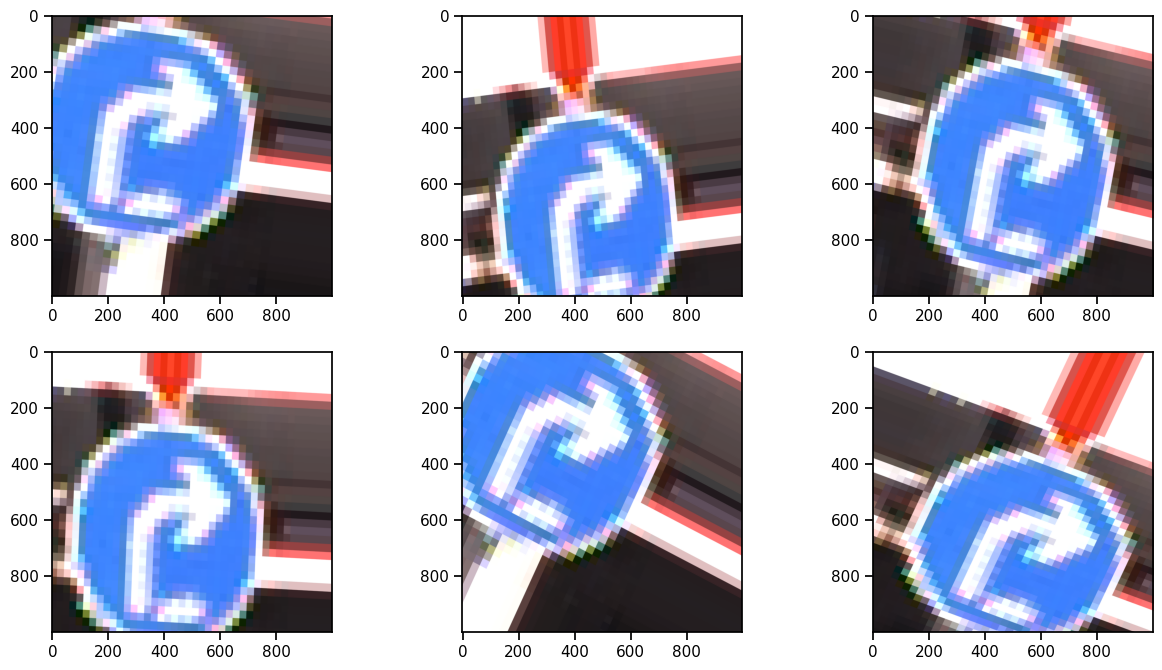

In [42]:
datagen = ImageDataGenerator(
                          horizontal_flip = False,
                          vertical_flip = False,
                          rotation_range = 30,
                          shear_range=0.15,
                          width_shift_range = 0.2,
                          height_shift_range = 0.2,
                          zoom_range=0.15
                         )

pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(15,8))
for i in range(1,7):
  plt.subplot(2, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

history[f'model_aug_history'] = models[f'model_2'].fit_generator(datagen.flow(X_train, 
                                                                  y_train),
                                                                  epochs = 50,
                                                                  validation_data=(X_valid, y_valid),
                                                                  callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                                                                               ModelCheckpoint(f'/content/drive/MyDrive/road-signs-NN/models/CNN_model_aug.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')],
                                                                  verbose=1)

with open(f'/content/drive/MyDrive/road-signs-NN/history/CNN_model_aug', 'wb') as file_pi:
            pickle.dump(history[f'model_aug_history'].history, file_pi)
        
print(f'''
      Total number of epochs is equal to {len(history[f'model_aug_history'].history['loss'])}
      The highest training accuracy is equal to {max(history[f'model_aug_history'].history['accuracy'])}.
      The highest validation accuracy is equal to {max(history[f'model_aug_history'].history['val_accuracy'])}.
      ''')

Epoch 1/50
981/981 [==============================] - 73s 74ms/step - loss: 1.3878 - accuracy: 0.5782 - val_loss: 0.7827 - val_accuracy: 0.7558
Epoch 2/50
981/981 [==============================] - 73s 75ms/step - loss: 1.3696 - accuracy: 0.5801 - val_loss: 0.7826 - val_accuracy: 0.7567
Epoch 3/50
981/981 [==============================] - 76s 77ms/step - loss: 1.3833 - accuracy: 0.5802 - val_loss: 0.8519 - val_accuracy: 0.7159
Epoch 4/50
981/981 [==============================] - 71s 72ms/step - loss: 1.3735 - accuracy: 0.5849 - val_loss: 0.7601 - val_accuracy: 0.7576
Epoch 5/50
981/981 [==============================] - 73s 74ms/step - loss: 1.3618 - accuracy: 0.5859 - val_loss: 0.7648 - val_accuracy: 0.7614
Epoch 6/50
981/981 [==============================] - 85s 86ms/step - loss: 1.3554 - accuracy: 0.5859 - val_loss: 0.7293 - val_accuracy: 0.7701
Epoch 7/50
981/981 [==============================] - 79s 81ms/step - loss: 1.3492 - accuracy: 0.5888 - val_loss: 0.7642 - val_accuracy:

In [44]:
with open('/content/drive/MyDrive/road-signs-NN/history/CNN_model_aug', "rb") as file_pi:
    history_final = pickle.load(file_pi)

model_aug = load_model('/content/drive/MyDrive/road-signs-NN/models/CNN_model_aug.h5')

val_loss, val_acc = model_aug.evaluate(X_valid, y_valid, verbose=2)
print('\nValidation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

test_loss, test_acc = model_aug.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

246/246 - 4s - loss: 0.7293 - accuracy: 0.7701 - 4s/epoch - 17ms/step

Validation accuracy: 0.7700841426849365

Validation loss: 0.7292693853378296
395/395 - 9s - loss: 260.2710 - accuracy: 0.4787 - 9s/epoch - 22ms/step

Test accuracy: 0.47870150208473206

Test loss: 260.2710266113281


Unfortunately, our model performs much worse, compared to the previous network, which is certainly not the expected result. 
One of the reasons might be that our model has simply too small capacity and it's not able to learn all the patterns in our data. \
Second - despite the exclusion of flips, it is possible that there are other parameters that we have overlooked that cause us to create new road signs with a completely different meaning.

395/395 [==============================] - 9s 24ms/step


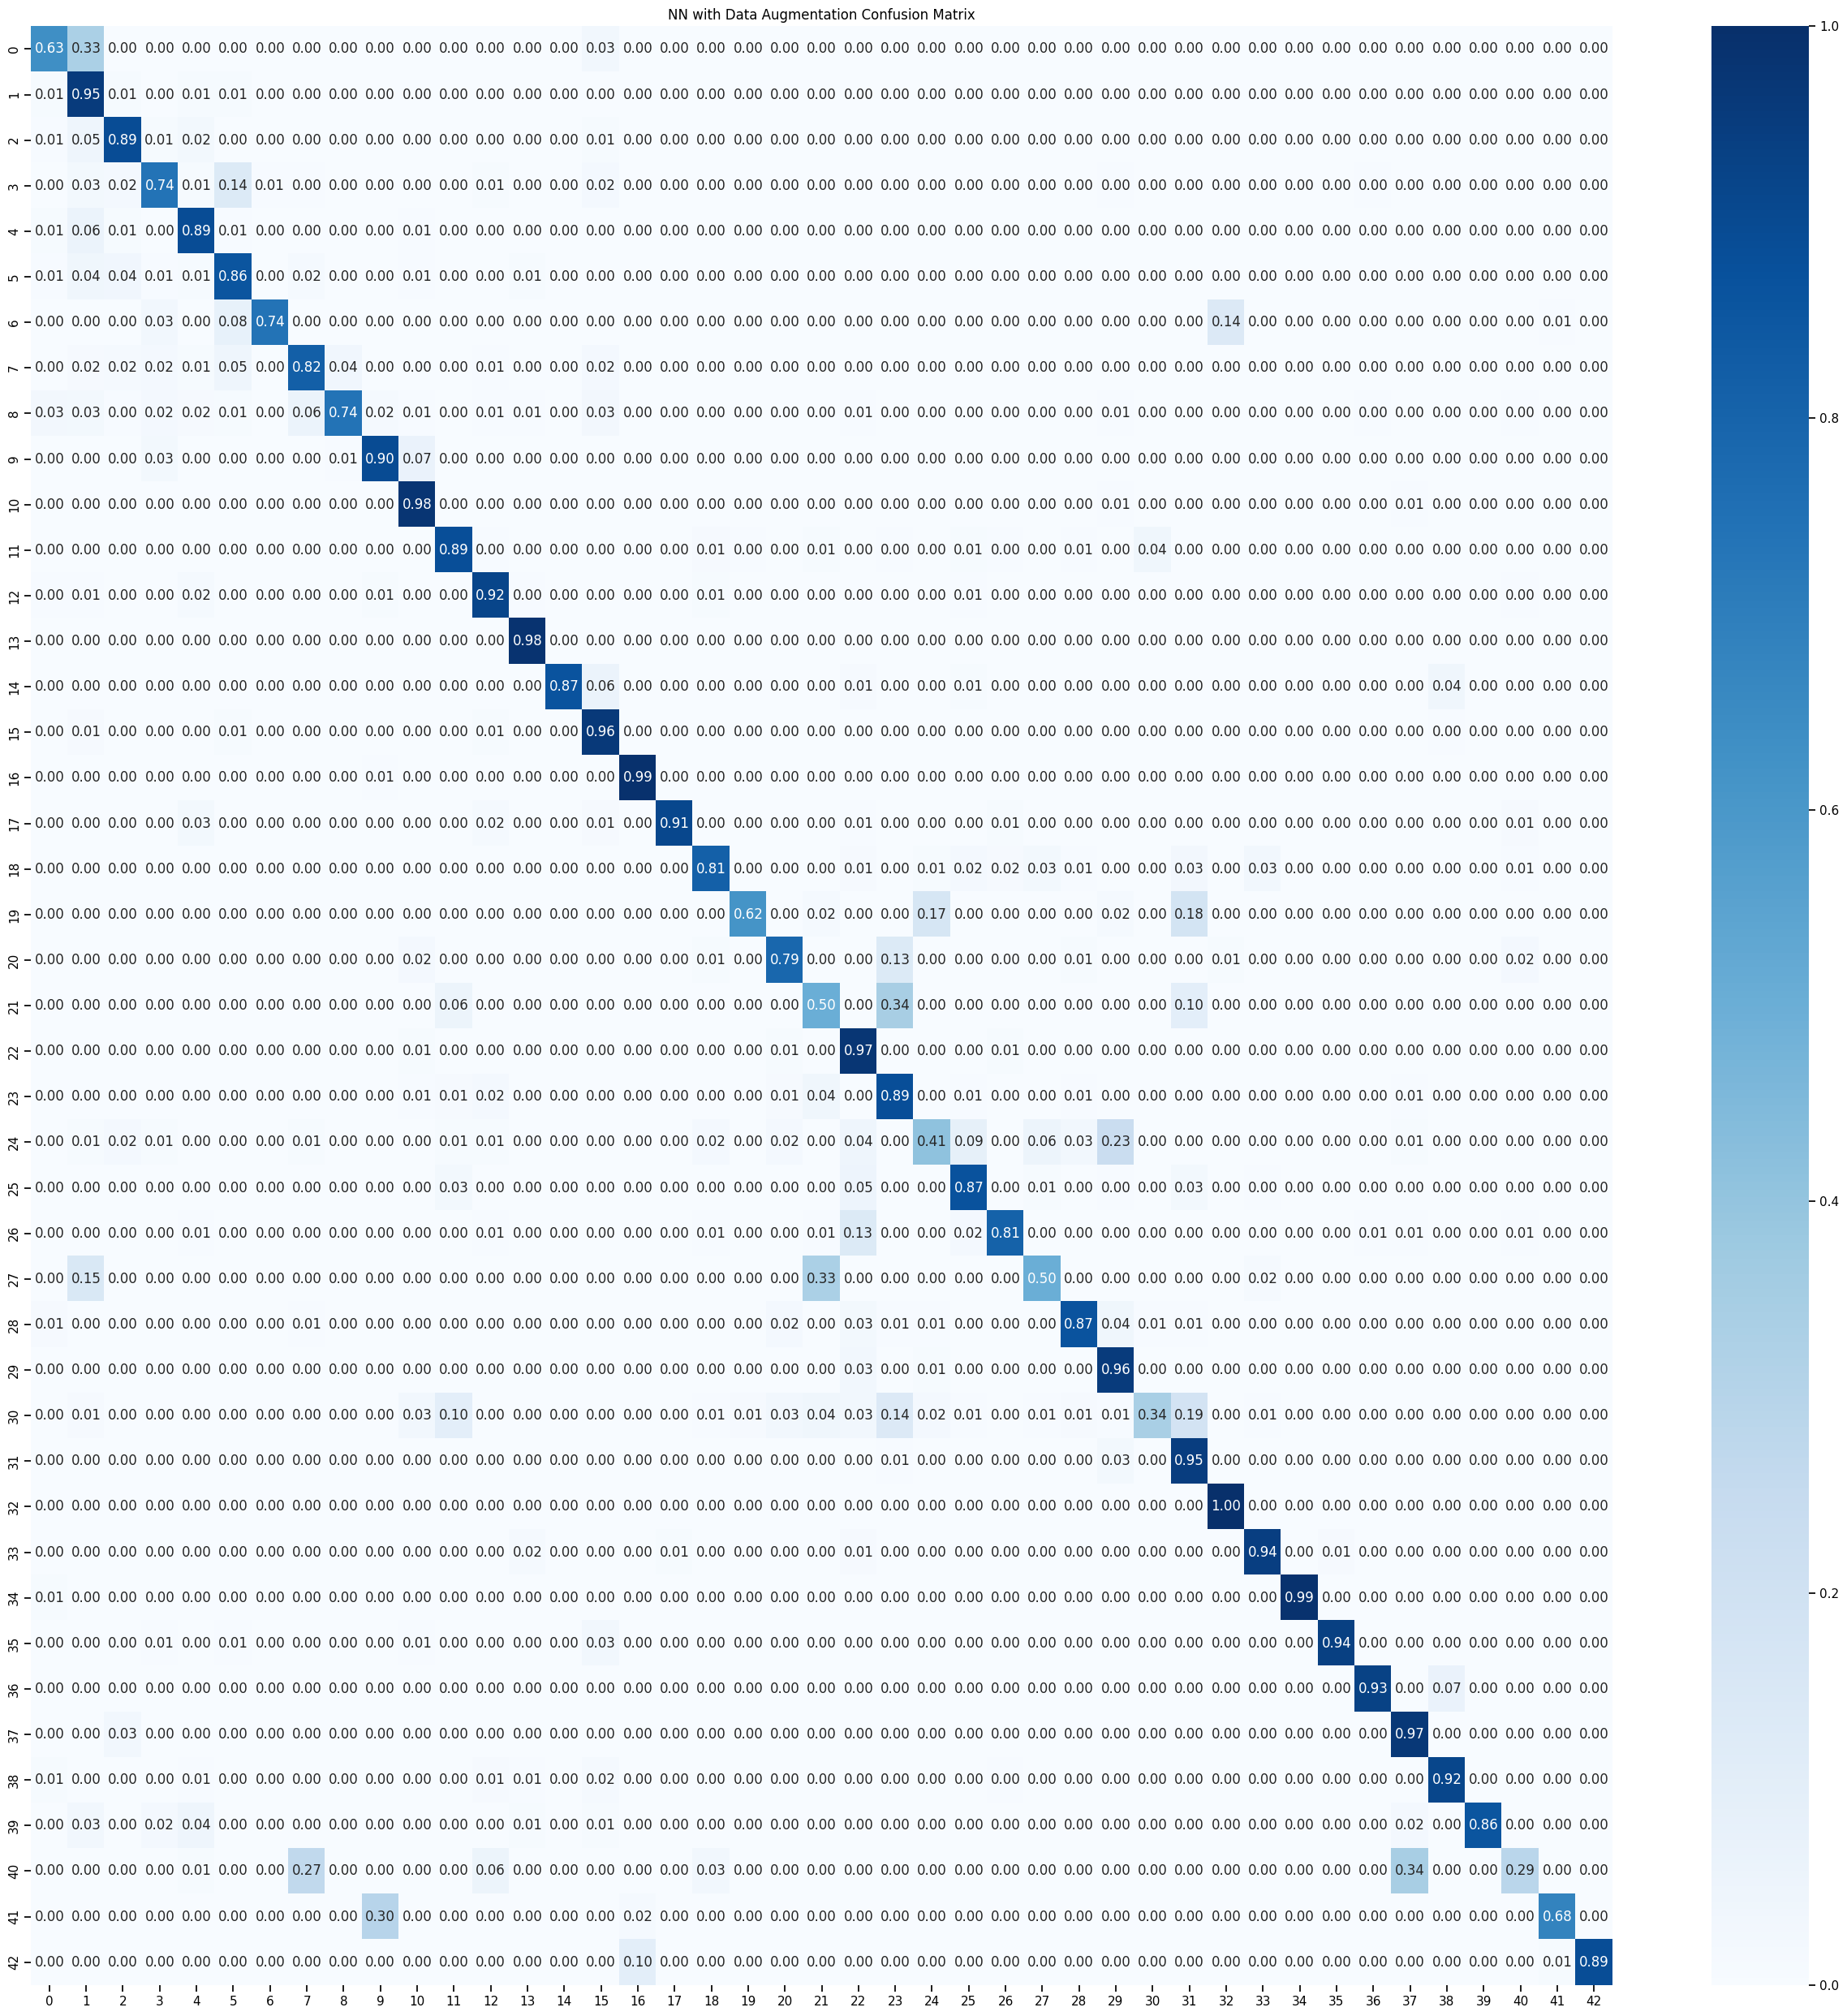

In [45]:
# Calculate predictions
# Predict the values from the test dataset
Y_pred = model_aug.predict(X_test)
# Convert one hot encoding to arg max
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert test observations to arg max
Y_true = np.argmax(y_test, axis=1)
  
# creating a confusion matrix 
cm_nn_aug = confusion_matrix(Y_true, Y_pred_classes)
cm_nn_aug = cm_nn_aug.astype('float') / cm_nn_aug.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_nn, annot = True, fmt='.2f', cmap="Blues").set_title("NN with Data Augmentation Confusion Matrix")
plt.tight_layout()

In the last step, let's see how our model predicts the road signs.

395/395 [==============================] - 9s 21ms/step


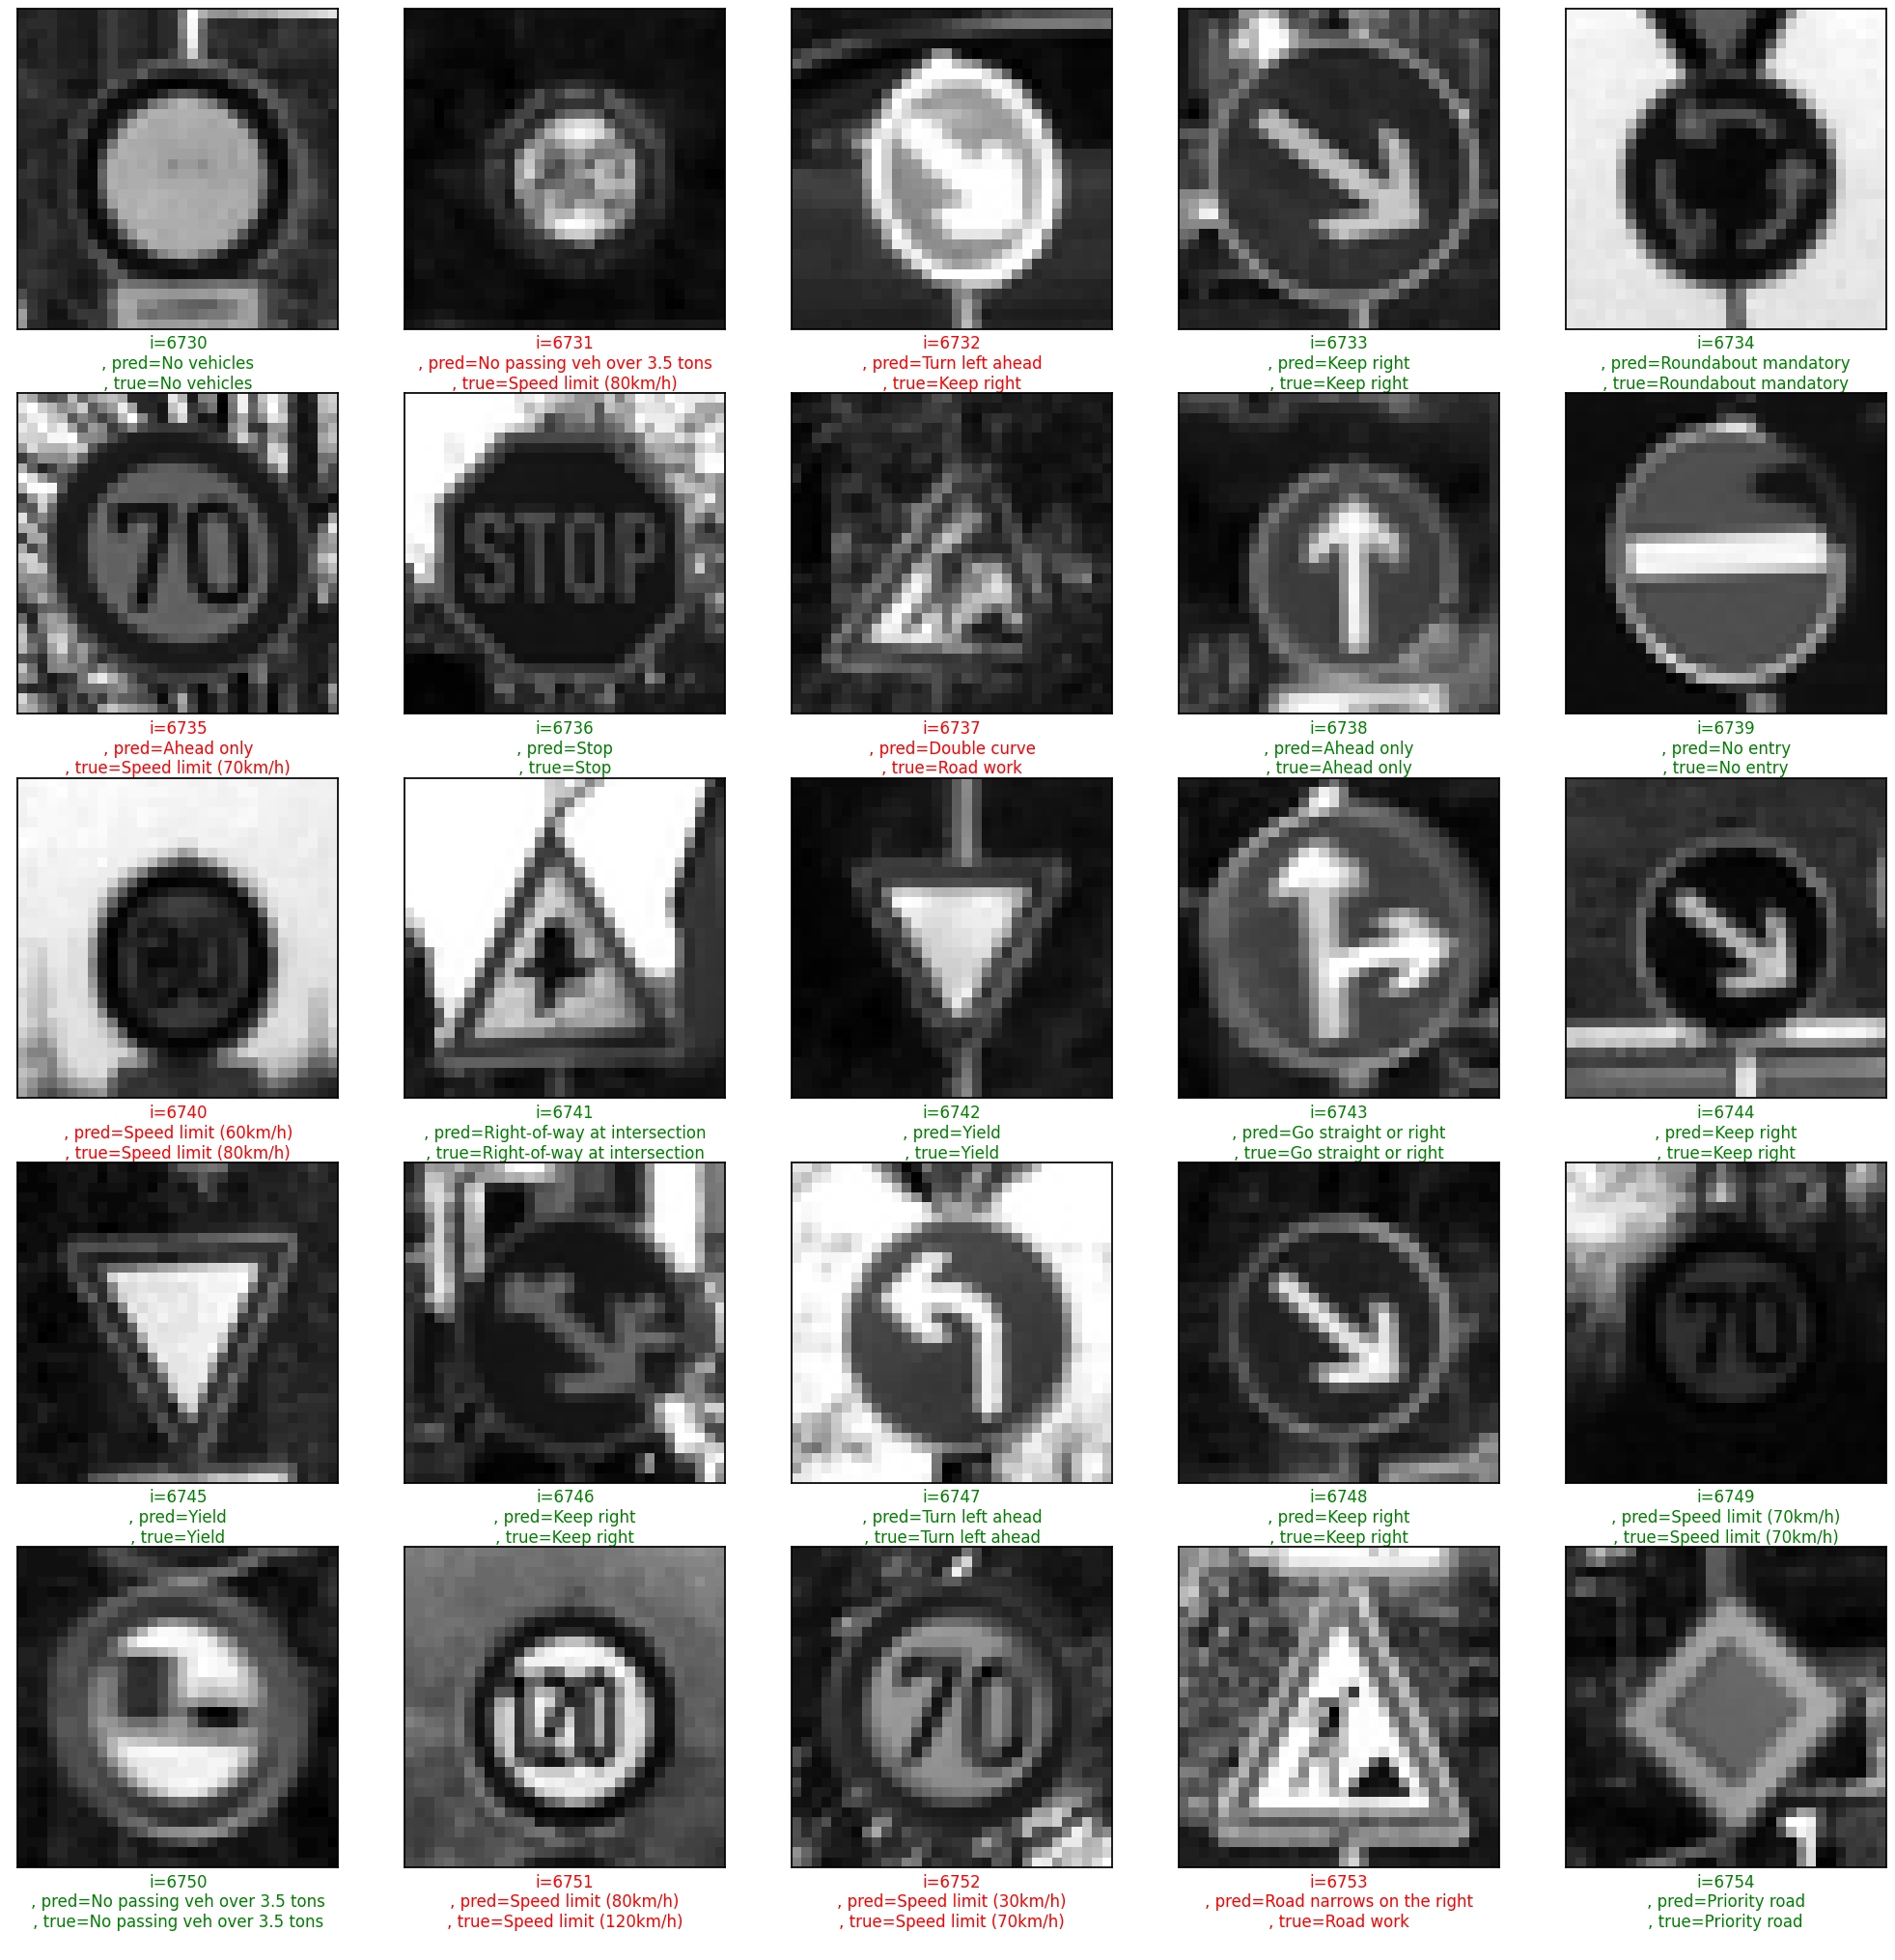

In [49]:
import random
preds = model_aug.predict(X_test)

plt.figure(figsize=(25, 25))
start_index = random.randint(0, 7800)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred = Y_pred_classes[start_index+i]
    true = Y_true[start_index+i]
    
    col = 'g'
    if pred != true:
        col = 'r'
    
    plt.xlabel('i={}\n, pred={}\n, true={}\n'.format(start_index+i, classes[pred], classes[true]), color=col)
    plt.imshow(X_test[start_index+i].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray')
plt.show()

##### 4.4. Transfer learning - VGG16 (optional)

As an addendum, we also prepared implementations of the VGG16 architecture for our problem. Originally, this was built on RGB images, whereas our collection has greyscale. Therefore, to get around this problem, we added an additional convolution layer.

We decided to make this point purely optional, as in our case one epoch counts over two hours.
Nevertheless, we wanted to show that in today's world, architectures that are already built earlier and earlier are being used, which would prove to be effective in many cases.

Since we include this subsection purely as a curiosity, or as a way to implement an RGB-based architecture to the problem of grey images, we did not go into the results obtained from this method.

We make no secret of the fact that the reason for this is very simple - time: it took us more than 3 hours to convert just one epoch.
Therefore, **we do not recommend** running the following code, but only present what can be done to apply transfer learning architectures trained on RGB images to the problem of classifying grayscale images

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Input

model_vgg19 = Sequential([
        Input(shape=(32, 32, 1)),
        Conv2D(3,(3,3),padding='same'),# add convolution layer to omit grayscale
        VGG16(weights='imagenet',include_top=False), 
        Flatten(),
        Dense(units=120, activation='relu'),
        Dense(units=43, activation='softmax')
        ])

model_vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture

model_vgg19.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 120)               61560     
                                                                 
 dense_11 (Dense)            (None, 43)                5203      
                                                                 
Total params: 14,781,481
Trainable params: 14,781,481
Non-trainable params: 0
___________________________________________

In [ ]:
history_vgg19 = model_vgg19.fit(X_train, 
                                y_train, 
                                epochs=5,
                                validation_data=(X_test, y_test),
                                batch_size = 216,
                                verbose=1)

#### 5. Summary

In our work, we used 3 models for the multiclassification problem, i.e. the classification of German road signs.
For models based on trees (i.e. RandomForest, LightGBM), we unfortunately could not achieve results that we were satisfied with.
For the neural network, the estimation on the validation set was improved and we were able to achieve an accuracy of almost 90% for the test set (however, the high value of loss function is still alarming). \
We believe this is a decent result, however we had in mind that our dataset is unbalanced so accuracy in this case might be misleading. That's why, we decided to augment the data while fitting it to the architecture of the best neural network. Unluckily, something went definitely wrong in our attempt. \
Based on our predicted photos, we see that resolution 32x32 almost blurred our photos. On the next attemptes maybe it would be worth to try to increase the resolution ang keep RGB scale.

Are we satisfied with our work? In terms of results perhaps not necessarily, but undoubtedly the project through trying to solve various problems has allowed us to gain a lot of valuable knowledge which we are happy with.



#### Resources

- http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
- https://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7
- https://towardsdatascience.com/classification-of-traffic-signs-with-lenet-5-cnn-cb861289bd62
- https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
- https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
- https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
- https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/